In [1]:
import json
from hanziconv import HanziConv
import jieba
import time

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

import numpy as np

from gensim.models import Word2Vec
from gensim.models.word2vec import PathLineSentences,LineSentence
from gensim.models import KeyedVectors
import os

In [93]:
def is_cn_or_en(uchar):
    """判断是否是汉字 或 英文"""
    return (u'\u4e00' <= uchar <= u'\u9fa5') or\
           (u'\u0041' <= uchar <= u'\u005a') or \
            (u'\u0061' <= uchar <= u'\u007a')

In [118]:
class Word2Vec_generater:
    '''
    用于生成 干净规整的词组，用于生成词向量。
    '''
    
    def __init__(self,corpus_path,stopwords_path,clean_path):
        '''
        配置语料文件夹，停用词文件夹。
        '''
        self.corpus_path = corpus_path
        self.stopwords_path = stopwords_path
        self.clean_path = clean_path
        self.stop_words = self.get_stop_words()
        
    def get_stop_words(self):
        '''
        生成停用词库。
        '''
        stop_words = []
        for file in os.listdir(self.stopwords_path):
            with open(self.stopwords_path+file) as f_stop:
                stop_words += [l[:-1] for l in f_stop.readlines()]
        stop_words += ['\n','「','「','{','〈']
        self.stop_words = set(stop_words)
        return stop_words
    def clean_segment_words(self,document):
        '''
        对每一条文档进行清洗。
        '''
        #繁体转化为简体。
        document = '' if document is None else document
        line_simplified = HanziConv.toSimplified(document)
        #结巴分词
        cutted_line = jieba.cut(line_simplified)
        # 去除停用词，去除非汉语，英语字符。
        cutted_line_rs = ' '.join([l.lower() for l in cutted_line \
                                   if all([is_cn_or_en(c) for c in l]) and (l not in self.stop_words)])
        return cutted_line_rs
    
    def process_corpus(self):
        '''
        对原始语料文件进行处理， 结果保存到文件中。d迭代读取文件控制内存占用。
        '''
        corpus = self.read_corpus()
        for file in corpus:
            start = time.time()
            file_name = file.name.split('/')[-1]
            save_file = open(self.clean_path+file_name,'w')
            for line in file:
                try:
                    json_doc = json.loads(line)
                    if file.name.startswith(self.corpus_path+'news'):
                        raw_line = json_doc
                    else:
                        raw_line = json_doc['text']
                    cleaned_doc = self.clean_segment_words(raw_line)
                    save_file.write(cleaned_doc+'\n')
                except Exception as e:
                    raise e
                    #print(e)   
            save_file.close()
            file.close()
            print('processing:{}, {}'.format(file.name,time.time()-start))
    
    def read_corpus(self):
        '''
        迭代地从预料中读取文件
        '''
        for i in os.listdir(self.corpus_path):
            yield open(self.corpus_path+i)
        

### 提取维基百科语料

```
./WikiExtractor.py --json -b 8M ../zhwiki-20190720-pages-articles-multistream.xml.bz2 -o text/
```

### 清洗新闻语料库

In [23]:
from sqlalchemy import create_engine, Table
import pandas as pd
import jieba

sql_url = 'mysql+pymysql://root:AI@2019@ai@rm-8vbwj6507z6465505ro.mysql.zhangbei.rds.aliyuncs.com/stu_db'
engine = create_engine(sql_url)
engine.table_names()

# with engine.connect() as conn:
#     resp = engine.execute('select * from news_chinese limit 10')

In [49]:
df_id = pd.read_sql('select id from news_chinese',engine)

In [61]:
import json

In [90]:
last_num = 0
file_seq = 0
appended_file = ''
while True:
    id_list = df_id.id[last_num:last_num+1000]
    
    if id_list.size == 0:
        break
    first ,last = str(id_list.iloc[0]), str(id_list.iloc[-1])
    SQL = 'select content from news_chinese where id >= {} and id <= {}'.format(first,last)
    df_part = pd.read_sql(SQL,engine)
    lines = ''.join([json.dumps(i,ensure_ascii=False)+'\n' for i in df_part.content])
    appended_file += lines
    last_num += 1000
    if len(appended_file) > 3100000:
        with open('../database/news_'+str(file_seq).zfill(2),'w') as f:
            f.write(appended_file)
            appended_file = ''
            file_seq += 1

    if id_list.size < 1000:
        break

### 清洗分词
结果保存文件

In [119]:
wvg = Word2Vec_generater('news_text/','stopwords/','clean/')
wvg.get_stop_words()
wvg.process_corpus()

processing:news_text/news_04, 20.617217779159546
processing:news_text/news_05, 18.158955574035645
processing:news_text/news_08, 17.74763059616089
processing:news_text/news_03, 17.11828923225403
processing:news_text/news_00, 16.585145711898804
processing:news_text/news_06, 17.414100885391235
processing:news_text/news_02, 15.833196640014648
processing:news_text/news_01, 16.227089881896973
processing:news_text/news_07, 16.820164680480957


### Word2Vec 生成词向量
Model 保存文件

In [6]:
start = time.time()
path_line_sentences = PathLineSentences('clean/')
model = Word2Vec(path_line_sentences, size=100, window=20, min_count=100, workers=4)
end = time.time()
print(end-start)
word_vector = model.wv
del model
word_vector.save('model/word2vec100.wv')

2800.1193788051605


### 仅仅使用新闻语料库

In [2]:
start = time.time()
path_line_sentences = PathLineSentences('news_clean/')
model = Word2Vec(path_line_sentences, size=64, window=20, min_count=30,workers=4)
end = time.time()
print(end-start)
word_vector = model.wv
#del model
word_vector.save('model/news_word2vec30.wv')

KeyboardInterrupt: 

In [ ]:
word_ve

In [2]:
word_vector = KeyedVectors.load('model/news_word2vec30.wv', mmap='r')

In [49]:
word_vector.vector_size

64

In [54]:
seg_words = jieba.lcut('香港升旗队总会总监许振隆勉励年轻人说，要关心社会，关心国家，希望年轻人以国为荣，为国争光')

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 3.502 seconds.
Prefix dict has been built succesfully.


In [56]:
[3 if i%3 ==0 else 20 for i in range(9)]

[3, 20, 20, 3, 20, 20, 3, 20, 20]

In [59]:
import pandas as pd

In [71]:
aver_vec = np.average([word_vector[w] if w in word_vector else np.zeros(word_vector.vector_size) for w in seg_words],axis=0)

In [74]:
from sklearn.metrics.pairwise import  cosine_similarity

In [83]:
cosine_similarity(np.array([[3,4]]),np.array([[4,9]]))

array([[0.97473232]])

In [53]:
np.sum([0,0])

0

In [3]:
word_vector.most_similar('认为',topn=30)

KeyError: "word '认为' not in vocabulary"

### TSNE 降维
降维后结果保存文件

In [ ]:
word_vector = KeyedVectors.load('model/word2vec.wv', mmap='r')

start = time.time()
label = np.array([l for l in word_vector.vocab])
tokens = np.array([word_vector[l] for l in word_vector.vocab])
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

new_values = tsne_model.fit_transform(tokens)
end = time.time()
print(end-start)

In [54]:
np.save('model/label.npy',label)
np.save('model/values.npy',new_values)

labels = np.load('model/label500.npy')
vectors = np.load('model/values500.npy')

### 使用Matplotlib 对降维后，词向量 画图显示

In [95]:
label_location = {k:i for i,k in enumerate(labels)}

In [168]:
def plot_by_coordinate(labels, vectors, coordinate,scale, highlight=None):
    '''
    输入坐标，得到局部的词向量图片
    labels 单词
    vectors 所有单词降维后坐标位置
    scale  上下作用边距
    highlight  用于 特殊显示的点
    '''
    c0 = (vectors[:,0] >= coordinate[0]-scale) & (vectors[:,0] <= coordinate[0]+scale)
    c1 = (vectors[:,1] >= coordinate[1]-scale) & (vectors[:,1] <= coordinate[1]+scale)
    
    selected = c0&c1
    data_num = np.sum(selected)
    print(data_num)
    if data_num > 100:
        print(' 你选择的区域内共有数据{}个，太多了，请重新选择！'.format(data_num))
        return
    selected_arg = np.argwhere(selected).flatten()
    #从整体中筛选出需要特别显示的点
    sele_values = vectors[selected_arg]
    sele_labels = labels[selected_arg]
    
    x, y = sele_values[:,0], sele_values[:,1]
    plt.figure(figsize=(16, 9)) 
    for i in range(sele_labels.shape[0]):
        marker = '*' if highlight and (sele_labels[i] in highlight) else None
        plt.scatter(x[i],y[i],marker=marker)
        plt.annotate(sele_labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 5),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

def plot_by_words(labels, vectors, word,scale):
    '''
    输入单词，得到其附近的词向量情况。
    '''
    index = label_location.get(word)
    if index is None:
        print('{} not exist'.format(word))
        return
    coordinate = vectors[index]
    plot_by_coordinate(labels, vectors, coordinate, scale, [word])

### 查看具体坐标附近的词向量

77


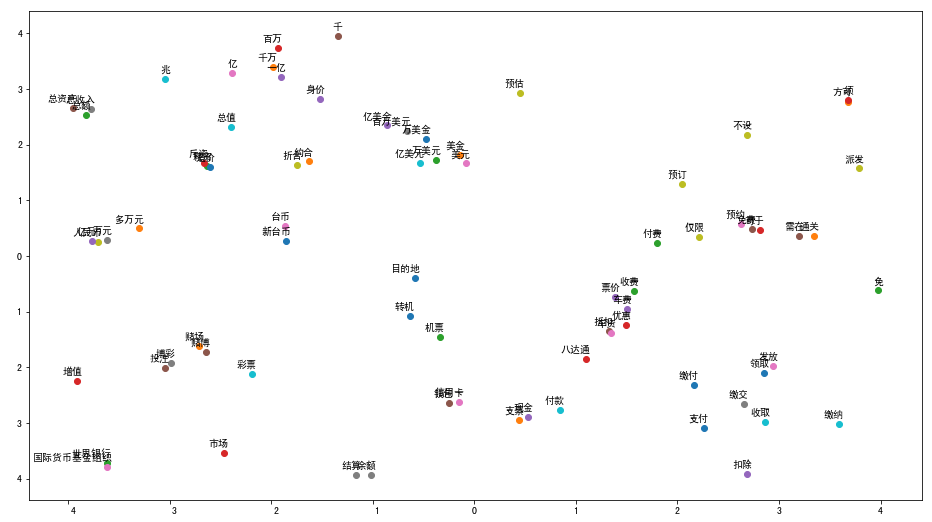

In [169]:
plot_by_coordinate(labels,vectors,(0,0),4)

### 查看某单词附近的词向量

131


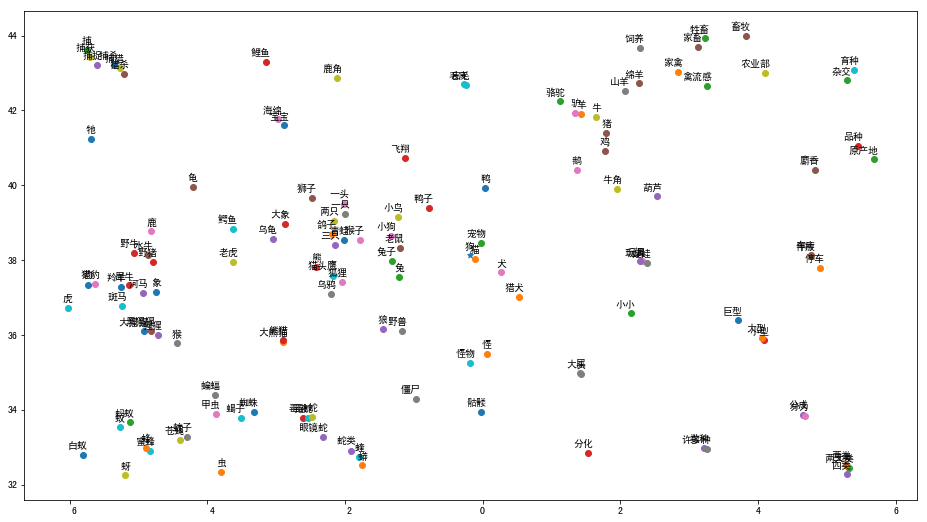

In [150]:
plot_by_words(labels,vectors,'狗',6)

###  获取相似单词，同义词，反义词距离

In [171]:
word_vector.most_similar('飞机')

[('这架', 0.6858986616134644),
 ('一架', 0.6676263809204102),
 ('客机', 0.661990761756897),
 ('飞行', 0.6618332862854004),
 ('机舱', 0.6417279839515686),
 ('架飞机', 0.639432430267334),
 ('水上飞机', 0.63924640417099),
 ('飞行员', 0.6313573122024536),
 ('航空器', 0.6232510805130005),
 ('直升机', 0.6222272515296936)]

In [178]:
word_vector.distance('河南','湖北')

0.389793336391449

In [186]:
word_vector.distance('河南','加州')

1.0968961715698242